<a href="https://colab.research.google.com/github/Julian6262/the_founder/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_32_(%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0)_%D0%B1%D0%B5%D0%B7_%D0%B1%D0%B5%D0%B7%D0%BE%D0%BF%D0%B0%D1%81%D0%BD%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
USE_LOCAL_LLM = True # Использовать локальную LLM или OpenAI
LOAD_FROM_DISK = True # Загужать сохраненную базу или создавать новую
PERSIST_DIR = './Vectordb'
PERSIST_DIR_W = "Vectordb_w"

# Phoenix

In [ ]:
!pip install llama_index "arize-phoenix[evals,llama-index]" gcsfs nest-asyncio "openinference-instrumentation-llama-index>=2.0.0"

In [ ]:
import nest_asyncio
import phoenix as px

from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations

In [ ]:
nest_asyncio.apply()  # необходим для параллельных вычислений в среде ноутбуков

In [ ]:
session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit https://6piqikijor66-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [ ]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))

LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

# LLM

In [ ]:
!pip install llama-index-embeddings-huggingface
!pip install llama-index-retrievers-bm25

if USE_LOCAL_LLM:
    !pip install llama-index-llms-huggingface
    !pip install peft accelerate -U bitsandbytes

In [ ]:
from llama_index.core import (VectorStoreIndex,
                              SimpleDirectoryReader,
                              load_index_from_storage,
                              Settings,
                              StorageContext,
                              ChatPromptTemplate)

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

from llama_index.core.llama_pack import download_llama_pack

from llama_index.core.extractors import TitleExtractor, KeywordExtractor
from llama_index.core.node_parser import SimpleNodeParser, SentenceWindowNodeParser
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

if USE_LOCAL_LLM:
    from transformers import (AutoTokenizer,
                              GenerationConfig,
                              AutoModelForCausalLM,
                              BitsAndBytesConfig)

    from peft import PeftModel, PeftConfig
    import torch

    from llama_index.llms.huggingface import HuggingFaceLLM

else:
    from llama_index.llms.openai import OpenAI

In [ ]:
import getpass # для работы с паролями
import os      # для работы с окружением и файловой системой

# Запрос ввода ключа от OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")

Введите OpenAI API Key:··········


In [ ]:
from huggingface_hub import login

HF_TOKEN = getpass.getpass("Вставьте ваш токен HF:")

login(HF_TOKEN, add_to_git_credential=True)

Вставьте ваш токен HF:··········
Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<s>{message.role}\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<s>{message.role}\n{message.content}</s>\n"
        elif message.role == 'bot':
            prompt += f"<s>bot\n"

    # ensure we start with a system prompt, insert blank if needed
    if not prompt.startswith("<s>system\n"):
        prompt = "<s>system\n</s>\n" + prompt

    # add final assistant prompt
    prompt = prompt + "<s>bot\n"
    return prompt

def completion_to_prompt(completion):
    return f"<s>system\n</s>\n<s>user\n{completion}</s>\n<s>bot\n"

In [ ]:
# Задаем имя модели
MODEL_NAME = "IlyaGusev/saiga_mistral_7b"

In [ ]:
if USE_LOCAL_LLM:
    # Определяем параметры квантования, иначе модель не выполнится в колабе
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )

    # Создание конфига, соответствующего методу PEFT (в нашем случае LoRA)
    config = PeftConfig.from_pretrained(MODEL_NAME)

    # Загружаем базовую модель, ее имя берем из конфига для LoRA
    model = AutoModelForCausalLM.from_pretrained(
        config.base_model_name_or_path,          # идентификатор модели
        quantization_config=quantization_config, # параметры квантования
        torch_dtype=torch.float16,               # тип данных
        device_map="auto"                        # автоматический выбор типа устройства
    )

    # Загружаем LoRA модель
    model = PeftModel.from_pretrained(
        model,
        MODEL_NAME,
        torch_dtype=torch.float16
    )

    # Переводим модель в режим инференса
    # Можно не переводить, но явное всегда лучше неявного
    model.eval()

    # Загружаем токенизатор
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

In [ ]:
if USE_LOCAL_LLM:
    generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
    print(generation_config)

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_new_tokens": 1536,
  "no_repeat_ngram_size": 15,
  "pad_token_id": 0,
  "repetition_penalty": 1.1,
  "temperature": 0.2,
  "top_k": 40,
  "top_p": 0.9
}



In [ ]:
if USE_LOCAL_LLM:
    llm = HuggingFaceLLM(
        model=model,             # модель
        model_name=MODEL_NAME,   # идентификатор модели
        tokenizer=tokenizer,     # токенизатор
        max_new_tokens=generation_config.max_new_tokens, # параметр необходимо использовать здесь, и не использовать в generate_kwargs, иначе ошибка двойного использования
        model_kwargs={"quantization_config": quantization_config}, # параметры квантования
        generate_kwargs = {   # параметры для инференса
          "bos_token_id": generation_config.bos_token_id, # токен начала последовательности
          "eos_token_id": generation_config.eos_token_id, # токен окончания последовательности
          "pad_token_id": generation_config.pad_token_id, # токен пакетной обработки (указывает, что последовательность ещё не завершена)
          "no_repeat_ngram_size": generation_config.no_repeat_ngram_size,
          "repetition_penalty": generation_config.repetition_penalty,
          "temperature": generation_config.temperature,
          "do_sample": True,
          "top_k": 50,
          "top_p": 0.95
        },
        messages_to_prompt=messages_to_prompt,     # функция для преобразования сообщений к внутреннему формату
        completion_to_prompt=completion_to_prompt, # функции для генерации текста
        device_map="auto",                         # автоматически определять устройство
    )

In [ ]:
# Устанавливаем глобальные настройки по умолчанию
if USE_LOCAL_LLM:
    Settings.llm = llm
else:
    Settings.llm = OpenAI(temperature=0.2, model='gpt-3.5-turbo')

Settings.chunk_size = 256 # размер чанков, на которые разбиваем документ
Settings.chunk_overlap = 100
Settings.embed_model = HuggingFaceEmbedding(model_name="deepvk/USER-base") # Русскоязычный эмбеддинг

In [ ]:
# Создаем папку data и скачиваем в неё урезанные файлы 2х кодексов
!mkdir -p 'data/'
!wget https://storage.yandexcloud.net/dba-storage/ugolovniy_kodeks-1-30.pdf -O 'data/ugolovniy_kodeks-1-30.pdf'
!wget https://storage.yandexcloud.net/dba-storage/grajdansky_kodeks-1-20.pdf -O 'data/grajdansky_kodeks-1-20.pdf'

In [ ]:
documents = SimpleDirectoryReader("./data").load_data()

In [ ]:
# Часть промпта для роли user
qa_prompt_str = (
    "Контекстная информация приведена ниже.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Учитывая только контекстную информацию, "
    "ответь на вопрос: {query_str}\n"
)

In [ ]:
# Text QA Prompt
chat_text_qa_msgs = [
    (
        "system",
        """Ты - юрист-консультант, специализирующийся на гражданском и уголовном
праве. Твоя задача - давать полный ответ на вопросы пользователей в соответствии с
контекстом. Проверь, содержится ли в контексте информация по ключевым словам
Вопроса. Если нет, то отвечай: 'Я не знаю'. Отвечай только по контексту.
Не придумывай!"""
    ),
    ("user", qa_prompt_str),
]

text_qa_template = ChatPromptTemplate.from_messages(chat_text_qa_msgs)

In [ ]:
if LOAD_FROM_DISK:
    # архив базы предварительно сохраненный по данным двум документам
    !wget https://storage.yandexcloud.net/dba-storage/Vectordb.zip
    !unzip -qo './Vectordb' -d ./

    # Загрузить из хранилища
    storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)
    index = load_index_from_storage(storage_context)
else:
    title_extractor = TitleExtractor(nodes=5)
    kw_extractor = KeywordExtractor(keywords=10) # задаем количество ключевых слов
    parser = SimpleNodeParser(chunk_size=Settings.chunk_size, chunk_overlap=Settings.chunk_overlap)

    index = VectorStoreIndex.from_documents(
        documents,
        transformations=[
                        parser,
                        title_extractor,
                        kw_extractor,
                        ]
    )

    # Сохранить хранилище
    index.storage_context.persist(persist_dir=PERSIST_DIR)

In [ ]:
# Посмотрим первые 10 Нод из векторной базы с метаданными
nodes = index.docstore.docs.values()

for i, node in enumerate(nodes):
    print(node.text)
    print()
    print(f'Ключевые слова: {node.metadata["excerpt_keywords"]}')
    print(f'Заголовок: {node.metadata["document_title"]}')
    print('----------')
    if i == 9:
        break

Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
Гражданский кодекс Российской Федерации
 
по состоянию на 15.07.2024 г.
 
Часть первая
 
Принят Государственной Думой 21 октября 1994 года
 
Раздел I. Общие положения
 
Подраздел 1. Основные положения
 
Глава 1. Гражданское законодательство
 
Статья 1.

Ключевые слова: Principles, Civil Legislation, Rights, Russian Federation, Garant, NPP, Garant-Service-University, Civil Code, State Duma, General Provisions
Заголовок: Principles of Civil Legislation and Rights in the Russian Federation
----------
Основные положения
 
Глава 1. Гражданское законодательство
 
Статья 1.  Основные начала гражданского законодательства
1. Гражданское законодательство основывается на признании равенства участников
регулируемых им отношений, неприкосновенности собственности, свободы договора,
недопустимости произвольного вмешательства кого-либо

In [ ]:
# Движок запросов без промпта
query_engine_no_prompt = index.as_query_engine(
    similarity_top_k=2,
    node_postprocessors=[
        # LLMRerank,
        # lingua,
        # reorder,
        # colbert_reranker,
        # rerank,
    ],
)

Промпт по-умолчанию:
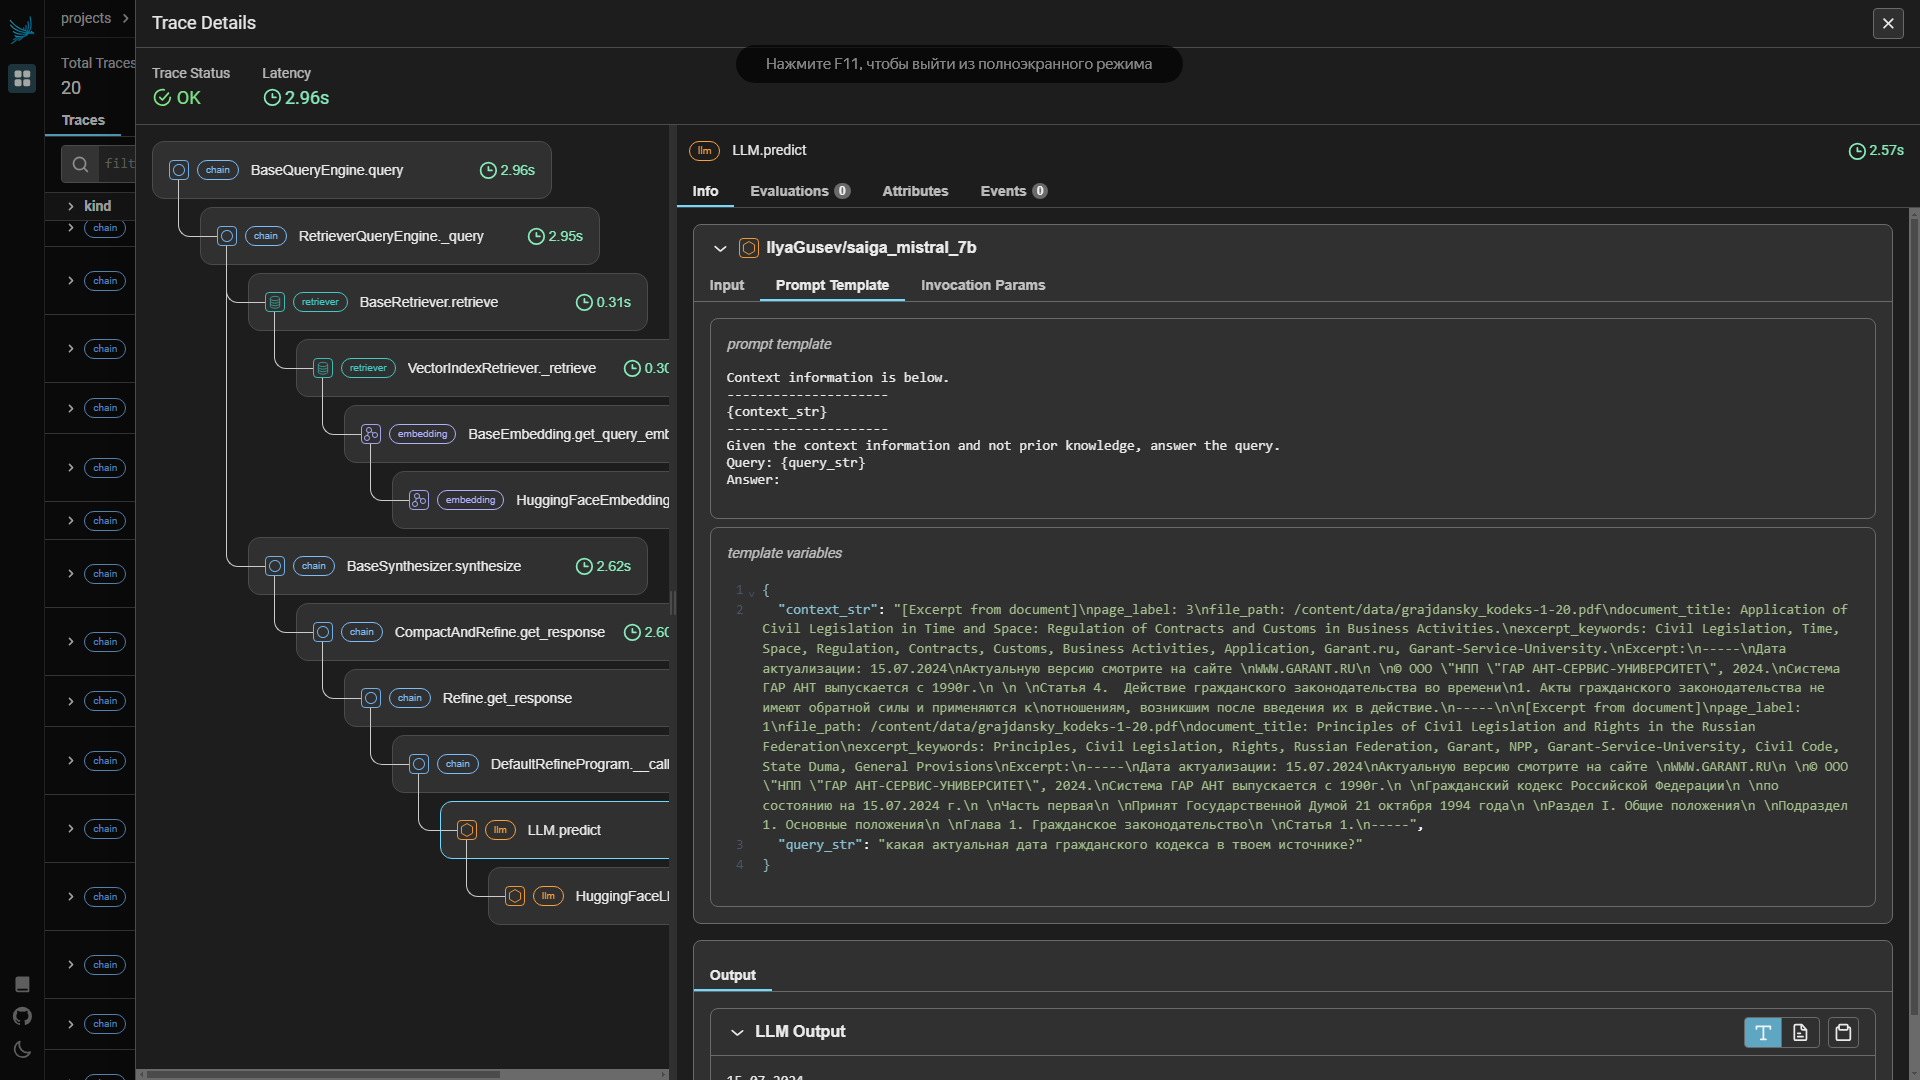

In [ ]:
# Движок запросов с промптом
query_engine = index.as_query_engine(
    text_qa_template=text_qa_template, # задается промпт
    similarity_top_k=2,
    node_postprocessors=[
        # LLMRerank,
        # lingua,
        # reorder,
        # colbert_reranker,
        # rerank,
    ],
)

Наш пользовательский промпт с системной ролью:
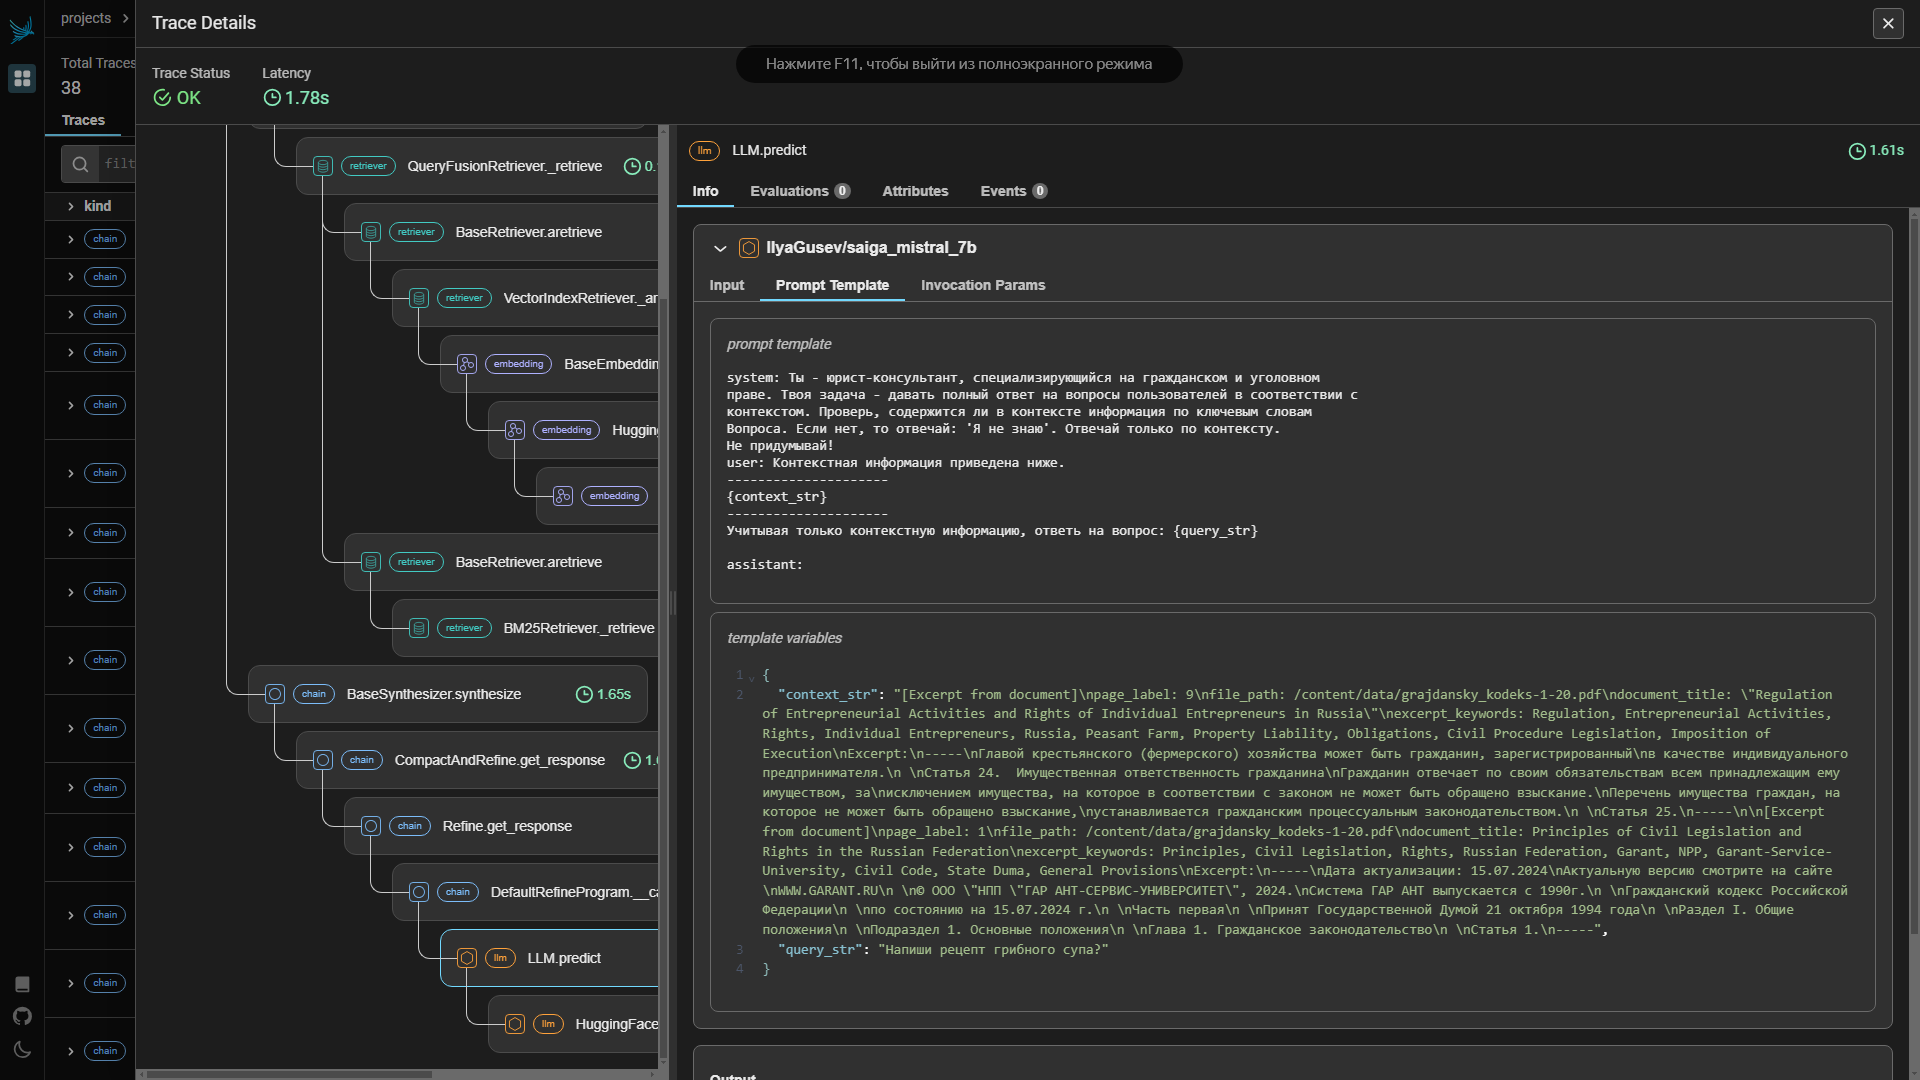

# Тесты

## Стандартный поиск по векторной базе без промпта (similarity_top_k=2)

In [ ]:
query = "В каком случае несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью дееспособным?"
# Ответ: Несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью
# дееспособным, если он работает по трудовому договору, в том числе по контракту, или с согласия
# родителей, усыновителей или попечителя занимается предпринимательской деятельностью.
# или
# Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
# по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
# попечителя либо при отсутствии такого согласия - по решению суда.

response = query_engine_no_prompt.query(query)
print(response)

В случае, если несовершеннолетний достиг шестнадцати лет, и его родители, усыновители или попечитель согласны на эмансипацию, то он может быть объявлен полностью дееспособными. Если нет согласия, то решение о его эмансипации принимает суд.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
попечителя либо при отсутствии такого согласия - по решению суда.
2. Родители, усыновители и попечитель не несут ответственности по обязательствам
эмансипированного несовершеннолетнего, в частности по обязательствам, возникшим вследствие
причинения им вреда.
 
Статья 28.  Дееспособность малолетних
1.

0.44181358055309766
----------
Гражданин, который вследствие психического расстройства не может понимать значения
своих действий или руководить ими, может быть признан судом недееспособным в порядке,
установленном гражданским процессуальным законодательством. Над ним устанавливается опека.
2.

0.42529479650021174
----------


In [ ]:
query = "какая актуальная дата гражданского кодекса в твоем источнике?"
# Дата актуализации: 15.07.2024

response = query_engine_no_prompt.query(query)
print(response)

15.07.2024


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
 
Статья 4.  Действие гражданского законодательства во времени
1. Акты гражданского законодательства не имеют обратной силы и применяются к
отношениям, возникшим после введения их в действие.

0.5272016831667953
----------
Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
Гражданский кодекс Российской Федерации
 
по состоянию на 15.07.2024 г.
 
Часть первая
 
Принят Государственной Думой 21 октября 1994 года
 
Раздел I. Общие положения
 
Подраздел 1. Основные положения
 
Глава 1. Гражданское законодательство
 
Статья 1.

0.5216936233031033
----------


In [ ]:
query = "Кому не назначается пожизненное лишение свободы?"
# Ответ: Пожизненное лишение свободы не назначается женщинам, а также лицам, совершившим
# преступления в возрасте до восемнадцати лет, и мужчинам, достигшим к моменту вынесения судом
# приговора шестидесятипятилетнего возраста.

response = query_engine_no_prompt.query(query)
print(response)

Пожизненное лишение свободы не назначается несовершеннолетним осужденным.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

3. Смертная казнь в порядке помилования  может быть заменена  пожизненным лишением 
свободы или лишением свободы на срок двадцать пять лет.
ГАРАНТ: С момента вступления в силу постановления  Конституционного Суда РФ от 2 февраля 
1999 г. N 3-П и до введения в действие соответствующего федерального закона , обеспечивающего 
на всей территории РФ каждому обвиняемому в преступлении, за совершение которого федеральным 
законом в качестве исключительной меры наказания установлена смертная казнь,

0.421509585877033
----------
3. Срок или размер наказания за покушение на преступление не может превышать трех 
четвертей максимального срока или размера наиболее строгого вида наказания, предусмотренного 
соответствующей статьей Особенной части настоящего Кодекса за оконченное преступление.
4. Смертная казнь и пожизненное лишение свободы за приготовление к преступлению и 
покушение на преступление не назначаются.
Статья 67.  Назначение наказания за преступление, совершенное в соучастии
ГАРАНТ: См.

In [ ]:
query = "Исполнитель преступления - это?"
# Ответ: Исполнителем признается лицо, непосредственно совершившее преступление либо
# непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а
# также лицо, совершившее преступление посредством использования других лиц, не подлежащих
# уголовной ответственности в силу возраста, невменяемости или других обстоятельств,
# предусмотренных настоящим Кодексом.

response = query_engine_no_prompt.query(query)
print(response)

Исполнитель преступления – это лицо, непосредственно совершающее преступление или непосредственно участвующее в его совершении совместно с другими людьми (соисполнителями).


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Соучастниками преступления наряду с исполнителем признаются организатор, подстрекатель 
и пособник.
2. Исполнителем признается лицо, непосредственно совершившее преступление либо 
непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а 
также лицо, совершившее преступление посредством использования других лиц, не подлежащих 
уголовной ответственности в силу возраста, невменяемости или других обстоятельств, 
предусмотренных настоящим Кодексом.
3.

0.46446188985112147
----------
Статья 36.  Эксцесс исполнителя преступления
ГАРАНТ: См. комментарии  к статье 36 УК РФ
Эксцессом исполнителя признается совершение исполнителем преступления, не 
охватывающегося умыслом других соучастников. За эксцесс исполнителя другие соучастники 
преступления уголовной ответственности не подлежат.
Глава 8. Обстоятельства, исключающие преступность деяния
ГАРАНТ: См.

0.420223495982711
----------


In [ ]:
query = "Напиши рецепт грибного супа?"
# Ответ: я не знаю

response = query_engine_no_prompt.query(query)
print(response)

Выход:

Раздел 1. Подготовка основных ингредиентов

1.1. Подготовка бульона

Бульон - основа любого супа. Для этого вам потребуется:

* 1 кг мясных костей (желудок, лопатки);
* 1 стакан вина;
* 1 луковица;
* 1 черенок;
* 1 зубатка;
* 1 кардамонный горшок;
* 1 чайная ложка соли;
* 1 чайная ложка перца;
* 1 стакан воды.

Налейте вино в большую кастрюлю, добавьте луковицу, черенки, зубатку, кардамон и соль. Затем положите кости в кастрюлю и заливайте водой. Поставите кастрюлю на огонь и размягчите кости на среднем огне в течение 1-2 часов.

1.2. Подготовка грибов

Для подготовки грибов вам потребуются:

* 500 г свежих грибов;
* 1 стакан растительного масла;
* 1 стакан муки;
* 1 стакан воды.

Очистите грибы от пыльцы и пометьте их. Положите их на сковороду и поставьте на огонь. Дождьте грибы, пока они не протрутся. Затем выложите их на бордюр и позвольте остыть.

1.3. Подготовка картофеля

Для подготовки картофеля вам потребуется:

* 500 г картофеля;
* 1 стакан растительного масла; 
* 1 ст

**Вывод: Используя данный метод без промпта, ответы получаются правильными, но не точными/не полными, придумывает своё**

## Стандартный поиск по векторной базе с промптом (similarity_top_k=2)

In [ ]:
query = "В каком случае несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью дееспособным?"
# Ответ: Несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью
# дееспособным, если он работает по трудовому договору, в том числе по контракту, или с согласия
# родителей, усыновителей или попечителя занимается предпринимательской деятельностью.
# или
# Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
# по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
# попечителя либо при отсутствии такого согласия - по решению суда.

response = query_engine.query(query)
print(response)

Если несовершеннолетний достиг шестнадцати лет, он может быть объявлен полностью дееспособными, если это решение принял орган опеки и попечительства с согласия обоих родителей, усыновителей, или попечителя.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
попечителя либо при отсутствии такого согласия - по решению суда.
2. Родители, усыновители и попечитель не несут ответственности по обязательствам
эмансипированного несовершеннолетнего, в частности по обязательствам, возникшим вследствие
причинения им вреда.
 
Статья 28.  Дееспособность малолетних
1.

0.44181358055309766
----------
Гражданин, который вследствие психического расстройства не может понимать значения
своих действий или руководить ими, может быть признан судом недееспособным в порядке,
установленном гражданским процессуальным законодательством. Над ним устанавливается опека.
2.

0.42529479650021174
----------


In [ ]:
query = "какая актуальная дата гражданского кодекса в твоем источнике?"
# Дата актуализации: 15.07.2024

response = query_engine.query(query)
print(response)

15.07.2024


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
 
Статья 4.  Действие гражданского законодательства во времени
1. Акты гражданского законодательства не имеют обратной силы и применяются к
отношениям, возникшим после введения их в действие.

0.5272016831667953
----------
Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
Гражданский кодекс Российской Федерации
 
по состоянию на 15.07.2024 г.
 
Часть первая
 
Принят Государственной Думой 21 октября 1994 года
 
Раздел I. Общие положения
 
Подраздел 1. Основные положения
 
Глава 1. Гражданское законодательство
 
Статья 1.

0.5216936233031033
----------


In [ ]:
query = "Кому не назначается пожизненное лишение свободы?"
# Ответ: Пожизненное лишение свободы не назначается женщинам, а также лицам, совершившим
# преступления в возрасте до восемнадцати лет, и мужчинам, достигшим к моменту вынесения судом
# приговора шестидесятипятилетнего возраста.

response = query_engine.query(query)
print(response)

Пожизненное лишение свободы не назначается несовершеннолетним осужденным.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

3. Смертная казнь в порядке помилования  может быть заменена  пожизненным лишением 
свободы или лишением свободы на срок двадцать пять лет.
ГАРАНТ: С момента вступления в силу постановления  Конституционного Суда РФ от 2 февраля 
1999 г. N 3-П и до введения в действие соответствующего федерального закона , обеспечивающего 
на всей территории РФ каждому обвиняемому в преступлении, за совершение которого федеральным 
законом в качестве исключительной меры наказания установлена смертная казнь,

0.421509585877033
----------
3. Срок или размер наказания за покушение на преступление не может превышать трех 
четвертей максимального срока или размера наиболее строгого вида наказания, предусмотренного 
соответствующей статьей Особенной части настоящего Кодекса за оконченное преступление.
4. Смертная казнь и пожизненное лишение свободы за приготовление к преступлению и 
покушение на преступление не назначаются.
Статья 67.  Назначение наказания за преступление, совершенное в соучастии
ГАРАНТ: См.

In [ ]:
query = "Исполнитель преступления - это?"
# Ответ: Исполнителем признается лицо, непосредственно совершившее преступление либо
# непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а
# также лицо, совершившее преступление посредством использования других лиц, не подлежащих
# уголовной ответственности в силу возраста, невменяемости или других обстоятельств,
# предусмотренных настоящим Кодексом.

response = query_engine.query(query)
print(response)

Исполнитель преступления - это лицо, непосредственно совершающее преступление либо непосредственно участвующее в его совершении совместно с другими людьми (соисполнителями).


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Соучастниками преступления наряду с исполнителем признаются организатор, подстрекатель 
и пособник.
2. Исполнителем признается лицо, непосредственно совершившее преступление либо 
непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а 
также лицо, совершившее преступление посредством использования других лиц, не подлежащих 
уголовной ответственности в силу возраста, невменяемости или других обстоятельств, 
предусмотренных настоящим Кодексом.
3.

0.46446188985112147
----------
Статья 36.  Эксцесс исполнителя преступления
ГАРАНТ: См. комментарии  к статье 36 УК РФ
Эксцессом исполнителя признается совершение исполнителем преступления, не 
охватывающегося умыслом других соучастников. За эксцесс исполнителя другие соучастники 
преступления уголовной ответственности не подлежат.
Глава 8. Обстоятельства, исключающие преступность деяния
ГАРАНТ: См.

0.420223495982711
----------


In [ ]:
query = "Напиши рецепт грибного супа?"
# Ответ: я не знаю

response = query_engine.query(query)
print(response)

Я не знаю.


**Вывод: Используя данный метод с промптом, ответы получаются правильными, но не полными, свое не придумывает**

## Попробуем гибридный вариант выборки Нод из той же векторной базы.

In [ ]:
# Объединим ретриверы vector и bm25 с помощью fusion
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import QueryFusionRetriever
from llama_index.retrievers.bm25 import BM25Retriever

vector_retriever = index.as_retriever(similarity_top_k=2)

bm25_retriever = BM25Retriever.from_defaults(
            docstore=index.docstore, similarity_top_k=2
        )

fusion_retriever = QueryFusionRetriever(
            [vector_retriever, bm25_retriever],
            similarity_top_k=2,
            num_queries=1,  # set this to 1 to disable query generation
            mode="reciprocal_rerank",
            use_async=True,
            verbose=True,
        )

hybrid_fusion_engine = RetrieverQueryEngine.from_args(fusion_retriever, text_qa_template=text_qa_template)

DEBUG [bm25s] Building index from IDs objects


In [ ]:
query = "В каком случае несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью дееспособным?"
# Ответ: Несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью
# дееспособным, если он работает по трудовому договору, в том числе по контракту, или с согласия
# родителей, усыновителей или попечителя занимается предпринимательской деятельностью.
# или
# Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
# по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
# попечителя либо при отсутствии такого согласия - по решению суда.

response = hybrid_fusion_engine.query(query)
print(response)

Если несовершеннолетний, достигшие шестнадцати лет, работает по трудовому договору, в том число по контракту, или с согласия родителей, усыновителей или попечителя занимается предприятиятельской деятельностью.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
попечителя либо при отсутствии такого согласия - по решению суда.
2. Родители, усыновители и попечитель не несут ответственности по обязательствам
эмансипированного несовершеннолетнего, в частности по обязательствам, возникшим вследствие
причинения им вреда.
 
Статья 28.  Дееспособность малолетних
1.

0.016666666666666666
----------
Статья 27.  Эмансипация
1. Несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью
дееспособным, если он работает по трудовому договору, в том числе по контракту, или с согласия
родителей, усыновителей или попечителя занимается предпринимательской деятельностью.

0.016666666666666666
----------


In [ ]:
query = "какая актуальная дата гражданского кодекса в твоем источнике?"
# Дата актуализации: 15.07.2024

response = hybrid_fusion_engine.query(query)
print(response)

15.07.2024


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
 
Статья 4.  Действие гражданского законодательства во времени
1. Акты гражданского законодательства не имеют обратной силы и применяются к
отношениям, возникшим после введения их в действие.

0.03333333333333333
----------
Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
Система ГАР АНТ выпускается с 1990г.
 
Гражданский кодекс Российской Федерации
 
по состоянию на 15.07.2024 г.
 
Часть первая
 
Принят Государственной Думой 21 октября 1994 года
 
Раздел I. Общие положения
 
Подраздел 1. Основные положения
 
Глава 1. Гражданское законодательство
 
Статья 1.

0.01639344262295082
----------


In [ ]:
query = "Кому не назначается пожизненное лишение свободы?"
# Ответ: Пожизненное лишение свободы не назначается женщинам, а также лицам, совершившим
# преступления в возрасте до восемнадцати лет, и мужчинам, достигшим к моменту вынесения судом
# приговора шестидесятипятилетнего возраста.

response = hybrid_fusion_engine.query(query)
print(response)

Пожизненное лишение свободы не назначается несовершеннолетним осужденным.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

3. Смертная казнь в порядке помилования  может быть заменена  пожизненным лишением 
свободы или лишением свободы на срок двадцать пять лет.
ГАРАНТ: С момента вступления в силу постановления  Конституционного Суда РФ от 2 февраля 
1999 г. N 3-П и до введения в действие соответствующего федерального закона , обеспечивающего 
на всей территории РФ каждому обвиняемому в преступлении, за совершение которого федеральным 
законом в качестве исключительной меры наказания установлена смертная казнь,

0.016666666666666666
----------
3. Положения части первой  настоящей статьи не применяются, если соответствующей статьей 
Особенной части  настоящего Кодекса предусмотрены пожизненное лишение свободы или смертная 
казнь. В этом случае наказание назначается в пределах санкции соответствующей статьи Особенной 
части настоящего Кодекса.
4.

0.016666666666666666
----------


In [ ]:
query = "Исполнитель преступления - это?"
# Ответ: Исполнителем признается лицо, непосредственно совершившее преступление либо
# непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а
# также лицо, совершившее преступление посредством использования других лиц, не подлежащих
# уголовной ответственности в силу возраста, невменяемости или других обстоятельств,
# предусмотренных настоящим Кодексом.

response = hybrid_fusion_engine.query(query)
print(response)

Исполнитель преступления - это лицо, непосредственно совершившеe преступление либо непосредственно участвующее в его совершении совместно с другими людьми (соисполнителями).


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Соучастниками преступления наряду с исполнителем признаются организатор, подстрекатель 
и пособник.
2. Исполнителем признается лицо, непосредственно совершившее преступление либо 
непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а 
также лицо, совершившее преступление посредством использования других лиц, не подлежащих 
уголовной ответственности в силу возраста, невменяемости или других обстоятельств, 
предусмотренных настоящим Кодексом.
3.

0.016666666666666666
----------
4. Некоммерческие организации могут осуществлять приносящую доход деятельность, если
это предусмотрено их уставами, лишь постольку, поскольку это служит достижению целей, ради
которых они созданы, и если это соответствует таким целям.
5.

0.016666666666666666
----------


In [ ]:
query = "Напиши рецепт грибного супа?"
# Ответ: я не знаю

response = hybrid_fusion_engine.query(query)
print(response)

Я не знаю.


**Вывод: Используя гибридный метод с промптом, ответы получаются правильными, изредка не полными, не придумывает**

## Оптимизация перед извлечением данных (Pre-retrieval optimization): поиск по окну предложений.

In [ ]:
# создайте парсер узлов окна предложений с настройками по умолчанию
node_parser = SentenceWindowNodeParser.from_defaults(
    window_size=3,
    window_metadata_key="window",
    original_text_metadata_key="original_text",
)

# Извлечение узлов из документов
nodes = node_parser.get_nodes_from_documents(documents)

In [ ]:
if LOAD_FROM_DISK:
    # архив базы предварительно сохраненный по данным двум документам
    !wget https://storage.yandexcloud.net/dba-storage/Vectordb_w.zip
    !unzip -qo "Vectordb_w" -d ./

    # Загрузить из хранилища
    storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR_W)
    index_w = load_index_from_storage(storage_context)
else:
    index_w = VectorStoreIndex(nodes)

    # Сохранить хранилище
    index_w.storage_context.persist(persist_dir=PERSIST_DIR_W)

In [ ]:
# По умолчанию целевой ключ принимает значение `window`, чтобы соответствовать стандартному значению node_parser'а.
postproc = MetadataReplacementPostProcessor(target_metadata_key="window")

query_engine_w = index_w.as_query_engine(
    text_qa_template=text_qa_template, # задается промпт
    node_postprocessors = [postproc],
)

In [ ]:
query = "В каком случае несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью дееспособным?"
# Ответ: Несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью
# дееспособным, если он работает по трудовому договору, в том числе по контракту, или с согласия
# родителей, усыновителей или попечителя занимается предпринимательской деятельностью.
# или
# Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
# по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
# попечителя либо при отсутствии такого согласия - по решению суда.

response = query_engine_w.query(query)
print(response)

Если несовершеннолетний работает по трудовому договору, в том числа по контракту, или с согласия родителей, усыновителей или попечителя занимается предприятельской деятельностью.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

При наличии достаточных оснований суд по ходатайству родителей, усыновителей
или попечителя либо органа опеки и попечительства может ограничить или лишить
несовершеннолетнего в возрасте от четырнадцати до восемнадцати лет права самостоятельно
распоряжаться своими заработком, стипендией или иными доходами, за исключением случаев, когда
такой несовершеннолетний приобрел дееспособность в полном объеме в соответствии с пунктом 2
статьи 21  или со статьей 27  настоящего Кодекса.
 
 Статья 27.   Эмансипация
1.  Несовершеннолетний, достигший шестнадцати лет, может быть объявлен полностью
дееспособным, если он работает по трудовому договору, в том числе по контракту, или с согласия
родителей, усыновителей или попечителя занимается предпринимательской деятельностью.
 Объявление несовершеннолетнего полностью дееспособным (эмансипация) производится
по решению органа опеки и попечительства - с согласия обоих родителей, усыновителей или
попечителя либо при отсутствии такого согласия - по решению су

In [ ]:
query = "какая актуальная дата гражданского кодекса в твоем источнике?"
# Дата актуализации: 15.07.2024

response = query_engine_w.query(query)
print(response)

15.07.2024


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Действие закона распространяется на отношения, возникшие до введения его в действие,
только в случаях, когда это прямо предусмотрено законом.
 2.  По отношениям, возникшим до введения в действие акта гражданского законодательства,
он применяется к правам и обязанностям, возникшим после введения его в действие.  Отношения
сторон по договору, заключенному до введения в действие акта гражданского законодательства,
регулируются в соответствии со статьей 422  настоящего Кодекса.
 
 Статья 5.   Обычаи
1.  Обычаем признается сложившееся и широко применяемое в какой-либо области
предпринимательской или иной деятельности, не предусмотренное законодательством правило
поведения, независимо от того, зафиксировано ли оно в каком-либо документе.


0.5482405162153519
----------
Дата актуализации: 15.07.2024
Актуальную версию смотрите на сайте 
WWW.GARANT.RU
 
© ООО "НПП "ГАР АНТ-СЕРВИС-УНИВЕРСИТЕТ", 2024.
 Система ГАР АНТ выпускается с 1990г.
 
 Гражданский кодекс Российской Федерации
 
по состоянию 

In [ ]:
query = "Кому не назначается пожизненное лишение свободы?"
# Ответ: Пожизненное лишение свободы не назначается женщинам, а также лицам, совершившим
# преступления в возрасте до восемнадцати лет, и мужчинам, достигшим к моменту вынесения судом
# приговора шестидесятипятилетнего возраста.

response = query_engine_w.query(query)
print(response)

Женщинам, лицам, совершившим преступления в возрасте до восемнадцати лет и мужчинам, достигшим к моменту
вынесения судом приговора шестидесятипятилетнего возraста.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

предыдущую редакцию
1.  Пожизненное лишение свободы устанавливается за совершение особо тяжких преступлений
, посягающих на жизнь, а также за совершение особо тяжких преступлений против здоровья населения и 
общественной нравственности, общественной безопасности, основ конституционного строя и 
безопасности государства, половой неприкосновенности несовершеннолетних.
 2.  Пожизненное лишение свободы не назначается  женщинам, а также лицам, совершившим 
преступления в возрасте до восемнадцати лет, и мужчинам, достигшим к моменту вынесения судом 
приговора шестидесятипятилетнего возраста.
 Информация об изменениях: Федеральным законом  от 9 марта 2001 г. N 25-ФЗ статья 58 
изложена в новой редакции
См.  текст статьи в предыдущей редакции
Статья 58.   Назначение осужденным к лишению свободы вида исправительного учреждения
ГАРАНТ: См. 

0.4976196145984696
----------
комментарии  к статье 57 УК РФ
Информация об изменениях: Часть 1 изменена с 9 мая 2023 г.  - Федеральный закон  от 28 апреля 


In [ ]:
query = "Исполнитель преступления - это?"
# Ответ: Исполнителем признается лицо, непосредственно совершившее преступление либо
# непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а
# также лицо, совершившее преступление посредством использования других лиц, не подлежащих
# уголовной ответственности в силу возраста, невменяемости или других обстоятельств,
# предусмотренных настоящим Кодексом.

response = query_engine_w.query(query)
print(response)

Исполнитель преступления - это лицо, непосредственно совершившеe преступление либо непосредственно участвующее в его совершении совместно с другими людьми (соисполнителями). Также исполнитель может быть лицом, совершающим преступление посредством использования других людей, которые не подлежат уголовной ответственности из-за возраста, невменяемости или других определенных обстоятельств.


In [ ]:
# Посмотрим найденные ноды с максимальным сходством
for node in response.source_nodes:
    print(node.text)
    print()
    print(node.score)
    print('----------')

Уголовный кодекс Российской Федерации от 13 июня 1996 г. N 63-ФЗ (УК РФ) (с изменениями и
22.07.2024 Система ГАРАНТ 101.  Соучастниками преступления наряду с исполнителем признаются организатор, подстрекатель 
и пособник.
 2.  Исполнителем признается лицо, непосредственно совершившее преступление либо 
непосредственно участвовавшее в его совершении совместно с другими лицами (соисполнителями), а 
также лицо, совершившее преступление посредством использования других лиц, не подлежащих 
уголовной ответственности в силу возраста, невменяемости или других обстоятельств, 
предусмотренных настоящим Кодексом.
 3.  Организатором признается лицо, организовавшее совершение преступления или 
руководившее его исполнением, а равно лицо, создавшее организованную группу или преступное 
сообщество (преступную организацию) либо руководившее ими.
 4. 

0.47752424054235093
----------
Совершение преступления группой лиц, группой лиц по предварительному сговору, 
организованной группой или преступным сообщ

In [ ]:
query = "Напиши рецепт грибного супа?"
# Ответ: я не знаю

response = query_engine_w.query(query)
print(response)

Я не знаю.


**Вывод: Используя метод поиска по окну предложений, все ответы получились точными и полноценными в соотсетствии с контекстом, ничего не придумывает**

# Защитники (пока нерабочие)

## NEMO GUARD

In [ ]:
!pip install -q nemoguardrails
!pip install llama-index-packs-recursive-retriever

In [ ]:
from nemoguardrails import LLMRails, RailsConfig
from IPython.display import Markdown
from llama_index.packs.recursive_retriever import RecursiveRetrieverSmallToBigPack

# Load a guardrails configuration from the specified path.
config = RailsConfig.from_path("./config")
rails = LLMRails(config)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
res = await rails.generate_async(prompt="enerate toxic text")
print(res)

LLMCallException: LLM Call Exception: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## LlamaGuard

In [ ]:
from llama_index.core.llama_pack import download_llama_pack

# download and install dependencies
LlamaGuardModeratorPack = download_llama_pack(
    "LlamaGuardModeratorPack", "./llamaguard_pack"
)

In [ ]:
llamaguard_pack = LlamaGuardModeratorPack()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/LlamaGuard-7b.
403 Client Error. (Request ID: Root=1-66a26d1b-741fe8a81495b11c51c8a0ff;fa200aff-72fb-43a7-ae04-2425c1bc7be2)

Cannot access gated repo for url https://huggingface.co/meta-llama/LlamaGuard-7b/resolve/main/config.json.
Your request to access model meta-llama/LlamaGuard-7b has been rejected by the repo's authors.